In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# does initial image preprocessing (blurring, remove noise, convert black background white text)
def initial_preprocess(img_path, gaussian_blur = 0):
    # read image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    orig = img.copy()
    
    # Do Gaussian Blur in order to remove noise
    if gaussian_blur != 0:
        img = cv2.GaussianBlur(img, (gaussian_blur, gaussian_blur), 0)
    
    # do adaptive thresholding and convert images to binary
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                 cv2.THRESH_BINARY,11,2)

    # convert to black on white 
    img = cv2.bitwise_not(img, img)

    # dilate the gridlines
    #kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
    #img = cv2.dilate(img, kernel)
    
    # find contours (Sudoku Grid)
    contours,hierarchy = cv2.findContours(img, 1, 2)
    contours = sorted(contours, key=cv2.contourArea, reverse=True) # sort contours by area
    polygon_arr = contours[0:5]  # extract up to 5 sudoku grid at once

    cropped_arr = []
    cropped_arr_orig = []
    bbox_arr = []
    orig_gray = img.copy()
    
    # enumerate to draw rectangle and crop
    for polygon in polygon_arr:
        x,y,w,h = cv2.boundingRect(polygon)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        bbox_arr.append((x,y,w,h))
        cropped_arr.append(orig_gray[y:y+h, x:x+w])
        cropped_arr_orig.append(orig[y:y+h, x:x+w])
    
    return cropped_arr, cropped_arr_orig, bbox_arr

In [3]:
# find all the edges that are rectangular and returns them
def find_edges(cropped_arr):
    all_edges = []
    
    for i in range(5):
        # detect edges
        img1 = cropped_arr[i].copy()

        # find contours (Sudoku Grid)
        contours,hierarchy = cv2.findContours(img1, 1, 2)
        contours = sorted(contours, key=cv2.contourArea, reverse=True) # sort contours by area
        polygon = np.array(contours[0]).reshape(-1,2) #take the largest contour region

        sums = [elem[0] + elem[1] for elem in polygon] # X + Y
        diff1 = [elem[0] - elem[1] for elem in polygon] # X - Y

        top_left = np.argmin(sums) # smallest X + Y values
        bottom_right = np.argmax(sums) # largest X + Y values
        bottom_left = np.argmin(diff1) # smallest X - Y values
        top_right = np.argmax(diff1) # largest X - Y values

        # convert to tuple
        edges = [tuple(polygon[top_left]), tuple(polygon[top_right]), 
                 tuple(polygon[bottom_right]), tuple(polygon[bottom_left])]
        all_edges.append(edges)

        # draw edges with gray circle
        #for elem_edge in edges:
        #    cv2.circle(img1, elem_edge, 3, (100,100,255), 2)
    
    return all_edges

In [4]:
# check if there are any valid sudoku
def find_valid_sudoku(all_edges, cropped_arr_orig):
    # filter only valid images
    valid_sudoku_images = list(range(5))
    to_remove = []

    # check if edges are within 50 pixels in the corner.
    for elem in valid_sudoku_images:
        if all_edges[elem][0][0] > 50 or all_edges[elem][0][1] > 50: # top left of image not very close to edge
            to_remove.append(elem)

    valid_sudoku_images = [x for x in valid_sudoku_images if x not in to_remove]  # remove invalid

    img_size_area = [elem.shape[0] * elem.shape[1] for elem in cropped_arr_orig] # find area
    max_area = np.max(img_size_area) # get maximum area
    for elem in valid_sudoku_images:
        if img_size_area[elem] / max_area < 0.5: # less than 50% of max area
            to_remove.append(elem)

    valid_sudoku_images = [x for x in valid_sudoku_images if x not in to_remove] # remove invalid
    
    # if no valid boxes are found just add the first box (most probably correct)
    if len(valid_sudoku_images) == 0:
        valid_sudoku_images.append(0)
        all_edges = []
        h,w = cropped_arr_orig[0].shape
        all_edges = [[(0,0), (h,0), (h,w), (0,w)],]
    
    return valid_sudoku_images

In [5]:
def distance_between(p1, p2):
    """Returns the euclidean distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

# warp the image into perspective
def warped_image(all_edges, cropped_arr_orig, valid_sudoku_images):
    all_M = []
    final_proc = []
    
    for idx, elem in enumerate(valid_sudoku_images): 
        # extract edges
        top_left, top_right, bottom_right, bottom_left = all_edges[elem][0], all_edges[elem][1], all_edges[elem][2], all_edges[elem][3]

        # get longest edge of rectangle to warp
        side = max([distance_between(top_left, top_right), 
                     distance_between(top_right, bottom_right),
                     distance_between(bottom_right, bottom_left),
                     distance_between(bottom_left, top_left),
                    ])

        # Describe a square with side of the calculated length, this is the new perspective we want to warp to
        pts2 = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

        # transforms image from tilted to straight
        pts1 = np.float32(all_edges[elem])

        # M is matrix for transformation
        M = cv2.getPerspectiveTransform(pts1,pts2)
        all_M.append(M)

        # output
        dst = cv2.warpPerspective(cropped_arr_orig[idx],M,(int(side),int(side)))
        final_proc.append(dst)
    
    return final_proc, all_M

In [6]:
# post process the warped image
def post_process_warped(final_proc, gauss_blur = 0):
    final_proc_final = []
    # preproces finalboard
    for elem in final_proc:
        if gauss_blur != 0:
            # gaussian blur
            proc = cv2.GaussianBlur(elem.copy(), (gauss_blur, gauss_blur), 0)
        else:
            proc = elem.copy()
        
        # Adaptive threshold using 11 nearest neighbour pixels
        proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

        # Invert colours, so gridlines have non-zero pixel values.
        # Necessary to dilate the image, otherwise will look like erosion instead.
        proc = cv2.bitwise_not(proc, proc)
        #kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
        #proc = cv2.dilate(proc, kernel)

        final_proc_final.append(proc)
    return final_proc_final

In [7]:
# find bounding box of digits
def find_bounding_box(inp_img, scan_top_left, scan_bot_right):
    img = inp_img.copy()
    h, w = img.shape

    max_area = 0
    seed_point = (None, None)

    # Loop through the image
    for x in range(scan_top_left[0], scan_bot_right[0]):
        for y in range(scan_top_left[1], scan_bot_right[1]):
            # if current square is white, fill it with grey
            # flood fill converts neighboring pixels with similar color to white
            if img.item(y, x) == 255 and x < w and y < h:  # Note that .item() appears to take input as y, x
                area = cv2.floodFill(img, None, (x, y), 64)
                if area[0] > max_area:  # Gets the maximum bound area which should be the grid, and set start pt
                    max_area = area[0]
                    seed_point = (x, y)

    # Colour everything grey (compensates for features outside of our middle scanning range)
    for x in range(w):
        for y in range(h):
            if img.item(y, x) == 255 and x < w and y < h:
                cv2.floodFill(img, None, (x, y), 64)

    mask = np.zeros((h + 2, w + 2), np.uint8)  # Mask that is 2 pixels bigger than the image (from documentation)

    # Highlight the main feature, fill it with white
    if all([p is not None for p in seed_point]):
        cv2.floodFill(img, mask, seed_point, 255)

    top, bottom, left, right = h, 0, w, 0
    
    # fill those that are grey with black to hide anything that is not the main feature
    for x in range(w):
        for y in range(h):
            if img.item(y, x) == 64:  # Hide anything that isn't the main feature
                cv2.floodFill(img, mask, (x, y), 0)
            
            # Find the bounding parameters (find the last contiguous x and y)
            if img.item(y, x) == 255:
                top = y if y < top else top
                bottom = y if y > bottom else bottom
                left = x if x < left else left
                right = x if x > right else right

    # returns the bounding box of the characters
    return left, top, right, bottom

In [8]:
# scale the digits
def scale_and_centre(img, size, margin=0, background=0):
    """Scales and centres an image onto a new background square."""
    h, w = img.shape

    def centre_pad(length):
        """Handles centering for a given length that may be odd or even."""
        if length % 2 == 0:
            side1 = int((size - length) / 2)
            side2 = side1
        else:
            side1 = int((size - length) / 2)
            side2 = side1 + 1
        return side1, side2

    def scale(r, x):
        return int(r * x)
    
    # if height greater than width, need to scale appropriately
    if h > w:
        t_pad = int(margin / 2)
        b_pad = t_pad
        ratio = (size - margin) / h
        w, h = scale(ratio, w), scale(ratio, h)
        l_pad, r_pad = centre_pad(w)
    else:
        l_pad = int(margin / 2)
        r_pad = l_pad
        ratio = (size - margin) / w
        w, h = scale(ratio, w), scale(ratio, h)
        t_pad, b_pad = centre_pad(h)

    img = cv2.resize(img, (w, h))
    img = cv2.copyMakeBorder(img, t_pad, b_pad, l_pad, r_pad, cv2.BORDER_CONSTANT, None, background)
    return cv2.resize(img, (size, size))

In [9]:
# split the images into cells
def process_to_cell(final_proc):
    # split into 9x9 grids
    board_arr = []
    for board in final_proc:
        one_side_length = board.shape[0] / 9
        temp = []
        for i in range(9):
            lc = int(i * one_side_length)
            for j in range(9):
                rc = int(j * one_side_length)
                # currbox raw just take the raw pixels
                currbox = board[lc:int(lc+one_side_length), rc:int(rc+one_side_length)]
                

                margin = int(currbox.shape[0] / 2.5)    
                # get bounding box, input the scanning region
                left, top, right, bottom = find_bounding_box(currbox, [margin, margin], 
                                                             [currbox.shape[0] - margin, currbox.shape[1] - margin]) 
                # there is no object in the current box (set everything to black)
                if left == top and right == bottom:
                    currbox = np.zeros((28,28))
                # crop the digits in the image
                else:
                    currbox = currbox[top:bottom + 2, left:right + 2]
                    # center and pad the images
                    currbox = scale_and_centre(currbox, 28,4)
                    # binary tresholding
                    currbox = cv2.threshold(currbox,80, 255, cv2.THRESH_BINARY)[1]

                # add them to the array row wise
                temp.append(currbox)            
        board_arr.append(temp)

    board_arr = np.array(board_arr)
    return board_arr

In [10]:
def load_model(model_path = 'digit_recognizer_best.h5'):    
    # load from saved pre-trained model (LeNet-5 Architecture modified)
    model = tf.keras.models.load_model(model_path)
    return model

In [11]:
# convert into numpy array
def convert_board_to_numpy(board_arr, model):
    sudoku_board = []

    for i in range(board_arr.shape[0]):
        temp = []
        for j in range(board_arr.shape[1]):
            if len(np.where(board_arr[i][j][7:17, 7:17].ravel() == 0)[0])/100 > 0.8:  # percentage of 0 which is black
                temp.append(0)
            else:
                curr_box = board_arr[i][j].reshape(1,28,28,1) / 255
                y_pred = np.argmax(model.predict(curr_box), axis=-1)[0]
                if y_pred == 0:
                    curr_pred = model.predict(curr_box).ravel()
                    maxs_idx = curr_pred.argsort()[-2:]
                    y_pred = maxs_idx[0]
                temp.append(y_pred)

        sudoku_board.append(temp)
    
    return sudoku_board

#### Sudoku Methods

In [39]:
# sets up sudoku board
def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [a+b for a in A for b in B]

digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
            [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) 
             for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
             for s in squares)

In [40]:
# sudoku methods
def parse_grid(grid):
    """Convert grid to a dict of possible values, {square: digits}, or
    return False if a contradiction is detected."""
    ## To start, every square can be any digit; then assign values from the grid.
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits and not assign(values, s, d):
            return False ## (Fail if we can't assign d to square s.)
    return values

def grid_values(grid):
    "Convert grid into a dict of {square: char} with '0' or '.' for empties."
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

In [41]:
def assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

def eliminate(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminate(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
    if len(dplaces) == 0:
        return False ## Contradiction: no place for this value
    elif len(dplaces) == 1:
        # d can only be in one place in unit; assign it there
        if not assign(values, dplaces[0], d):
            return False
    return values

In [42]:
# display board
def display(values):
    "Display these values as a 2-D grid."
    width = 1+max(len(values[s]) for s in squares)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print (''.join(values[r+c].center(width)+('|' if c in '36' else '')
                      for c in cols))
        if r in 'CF': print (line)
    print()

In [43]:
# solve sudoku
# https://norvig.com/sudoku.html
def solve(grid): 
    return search(parse_grid(grid))

def search(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in squares): 
        return values ## Solved!
    ## Chose the unfilled square s with the fewest possibilities
    n,s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    return some(search(assign(values.copy(), s, d)) for d in values[s])

def some(seq):
    "Return some element of seq that is true."
    for e in seq:
        if e: return e
    return False

In [45]:
gaussian_blur_tresh = 5

# does initial preprocessing of images and obtain up to 5 boxes for sudoku
# orig is for the non-preprocessed image
cropped_arr, cropped_arr_orig, bbox_arr = initial_preprocess('dataset/image0.jpg', gaussian_blur_tresh)

# find edges of each of the boxes
all_edges = find_edges(cropped_arr)

# eliminate invalid sudoku boxes
valid_sudoku_images = find_valid_sudoku(all_edges, cropped_arr_orig)
print('valid sudoku images: ', valid_sudoku_images)

# take out unneded boxes
cropped_arr = [x for idx, x in enumerate(cropped_arr) if idx in valid_sudoku_images]
cropped_arr_orig = [x for idx, x in enumerate(cropped_arr_orig) if idx in valid_sudoku_images]

# warp and transform on original image (not preprocessed)
final_proc, all_M = warped_image(all_edges, cropped_arr_orig, valid_sudoku_images)

# now preprocess the cropped and warped image
final_proc = post_process_warped(final_proc, gaussian_blur_tresh)

# split the board into cells and clean the images
board_arr = process_to_cell(final_proc)

# load model
model = load_model('digit_recognizer_best.h5')

# convert board into numpy array
sudoku_board = convert_board_to_numpy(board_arr, model)

# manual correction
sudoku_board[0][4] = 8
sudoku_board[0][37] = 8
sudoku_board[0][66]= 8

# iterate through all sudoku board
for elem in sudoku_board:
    a_str = ''.join(str(x) for x in elem)
    try:
        display(solve(a_str))
    except:
        print('error in sudoku read')

valid sudoku images:  [0, 1]
3 4 1 |2 8 6 |5 7 9 
2 5 6 |1 7 9 |3 4 8 
8 9 7 |4 5 3 |1 2 6 
------+------+------
1 2 3 |7 4 8 |6 9 5 
7 8 9 |3 6 5 |2 1 4 
4 6 5 |9 1 2 |7 8 3 
------+------+------
5 1 2 |6 9 4 |8 3 7 
6 3 4 |8 2 7 |9 5 1 
9 7 8 |5 3 1 |4 6 2 

error in sudoku read


In [46]:
display(solve('300286009050179040000000000103040605780305014405010703000000000030827050900531002'))

3 4 1 |2 8 6 |5 7 9 
2 5 6 |1 7 9 |3 4 8 
8 9 7 |4 5 3 |1 2 6 
------+------+------
1 2 3 |7 4 8 |6 9 5 
7 8 9 |3 6 5 |2 1 4 
4 6 5 |9 1 2 |7 8 3 
------+------+------
5 1 2 |6 9 4 |8 3 7 
6 3 4 |8 2 7 |9 5 1 
9 7 8 |5 3 1 |4 6 2 



In [24]:
print(sudoku_board[1][1])

0


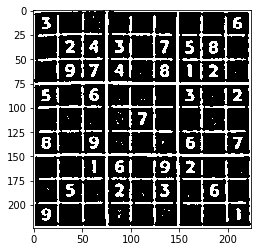

In [19]:
plt.imshow(final_proc[1], 'gray')

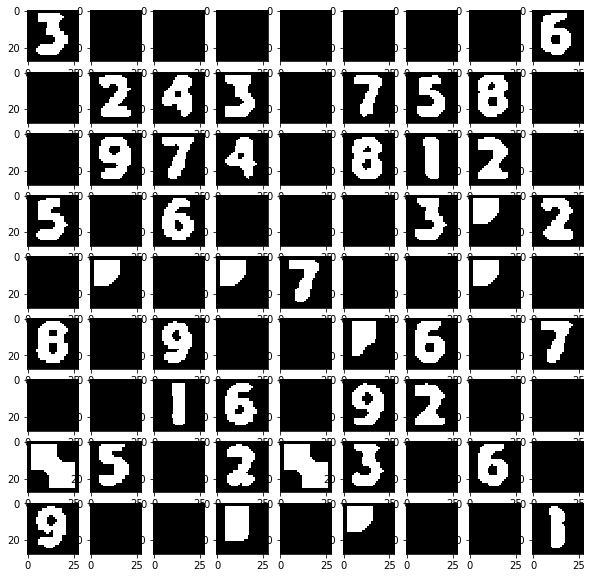

In [20]:
fig, ax =  plt.subplots(9,9, figsize=(10,10))
ax = ax.ravel()

for idx in range(81):    
    ax[idx].imshow(board_arr[1][idx], 'gray')

In [21]:

blank = cv2.imread('blank_grid.jpg')
blank = cv2.resize(blank, (270,270))


for i in range(9):
    for j in range(9):
        cv2.putText(blank,"0", (6 + (i*30), 25 + (j*30)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2);

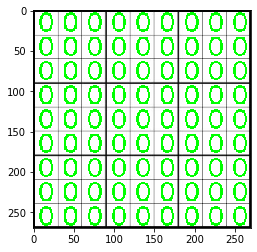

In [22]:
plt.imshow(blank)

In [36]:
a = '[[3 0 0 0 0 0 0 0 6] [0 2 4 3 0 7 5 6 0] [0 9 7 4 0 8 1 2 0] [5 0 6 0 0 0 3 9 2] \
 [0 9 0 9 7 0 0 9 0] \
 [6 0 9 0 0 9 6 0 7] \
 [0 0 1 6 0 9 2 0 0] \
 [4 5 0 2 4 3 0 6 0] \
 [9 0 0 4 0 9 0 0 6]]'

board_list = []
for elem in a:
    if elem == ' ':
        pass
    elif elem in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
        board_list.append(elem)

board_list = np.array(board_list).astype(np.uint8).reshape(9,9)

In [38]:
board_list

array([[3, 0, 0, 0, 0, 0, 0, 0, 6],
       [0, 2, 4, 3, 0, 7, 5, 6, 0],
       [0, 9, 7, 4, 0, 8, 1, 2, 0],
       [5, 0, 6, 0, 0, 0, 3, 9, 2],
       [0, 9, 0, 9, 7, 0, 0, 9, 0],
       [6, 0, 9, 0, 0, 9, 6, 0, 7],
       [0, 0, 1, 6, 0, 9, 2, 0, 0],
       [4, 5, 0, 2, 4, 3, 0, 6, 0],
       [9, 0, 0, 4, 0, 9, 0, 0, 6]], dtype=uint8)